<a href="https://colab.research.google.com/github/AkindeKadjo/Solubility_GNN/blob/main/Predicting_solubility_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**By Akinde Kadjo**

**Introduction**

The goal of this project is to predict molecule solubilities using GNN. This is a grapgh regression analysis. The data set used is from the Pytorch geometric datasets, specifically: [MoleculeNet](https://https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.MoleculeNet.html). The molecules infos are already pre-processed using RDKit where graphs are molecules, nodes are atoms, and edges are chemical bonds.

#Installs

In [1]:
!pip install rdkit-pypi
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=93bb89f07054f4ed960cfbb1c27d8ab92a446c240ed04b77d08f1f7184ed5875
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


#Loading libraries and Data

In [2]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

import torch
from torch.nn import Linear
import torch.nn.functional as F

import torch_geometric
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
import warnings
warnings.filterwarnings("ignore")

**ESOL Data set background:**

It originates from the [MoleculeNet collection](https://https://moleculenet.org/datasets-1).

"ESOL is a small dataset consisting of water solubility data for 1128 compounds. The dataset has been used to train models that estimate solubility directly from chemical structures (as encoded in SMILES strings). Note that these structures don’t include 3D coordinates, since solubility is a property of a molecule and not of its particular conformers."

In [3]:
#Data Loading (ESOL dataset)
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

#Dataset Exploration

##Overall Dataset

In [4]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>


Although I couldn't find more details on the data processing of this dataset, common node features and edge features are as below.

**Node features:**
Atomic number, Chirality, Degree (# directly-bonded neighbors), Formal charge, Number of H, Number of radical e, Hybridization, Is aromatic, Is in ring.

**Edge features:**
Bond type, Bond configuration, Is conjugated.


##First Molecule

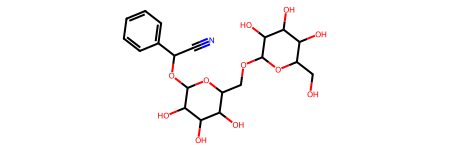

In [5]:
#Visual of the first molecule
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [6]:
#smiles
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

In [7]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [8]:
# Investigating the edges in sparse COO format (set of tuple of connection)
# Shape [2, num_edges]
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [9]:
#Investigating its solubility
data[0].y

tensor([[-0.7700]])

#GNN regression

##Implementing GNN

In [10]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


I used a template GNN and slightly modified it. The GNN architecture is that of a graph-level prediction (regression).

3 convolutional layers: learns the information about the 3 nearest atoms.
Since this is a regression problem we use a Linear layer as final output layer.

##Training GNN

In [11]:
# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665948867797852
Epoch 100 | Train Loss 0.8539249897003174
Epoch 200 | Train Loss 1.1192317008972168
Epoch 300 | Train Loss 0.3274688720703125
Epoch 400 | Train Loss 0.23006509244441986
Epoch 500 | Train Loss 0.361742228269577
Epoch 600 | Train Loss 0.23209774494171143
Epoch 700 | Train Loss 0.08683087676763535
Epoch 800 | Train Loss 0.13556765019893646
Epoch 900 | Train Loss 0.09944085776805878
Epoch 1000 | Train Loss 0.04775869846343994
Epoch 1100 | Train Loss 0.07836274057626724
Epoch 1200 | Train Loss 0.1513468325138092
Epoch 1300 | Train Loss 0.028985928744077682
Epoch 1400 | Train Loss 0.04912875220179558
Epoch 1500 | Train Loss 0.011091182939708233
Epoch 1600 | Train Loss 0.04846945405006409
Epoch 1700 | Train Loss 0.030712846666574478
Epoch 1800 | Train Loss 0.09393026679754257
Epoch 1900 | Train Loss 0.09665313363075256


<Axes: >

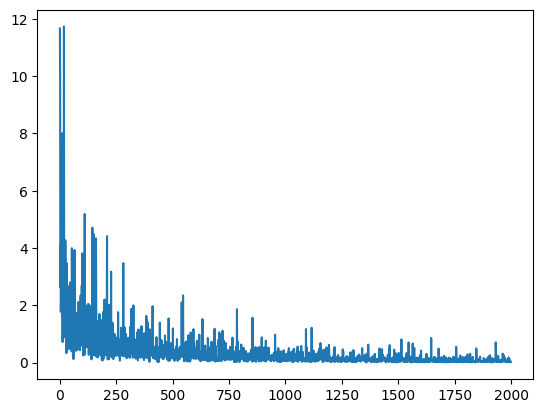

In [12]:
#Visualizing the training loss
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
sns.lineplot(x= loss_indices, y = losses_float)

##Test data prediction

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [14]:
#creating a data frame output of the metrics
def res_regression(ytest,test_pred,ytrain, train_pred):
    """Output regression metrics for both the test and the train data"""
    #test metrics
    mse_test = mean_squared_error(ytest, test_pred)
    rmse_test = np.sqrt(mse_test).round(4)
    r2_test = r2_score(ytest, test_pred).round(4)
    res_df_test = pd.DataFrame([rmse_test,r2_test], columns=['Test data'],index=['RMSE','R2'])
    #train metrics
    mse_train = mean_squared_error(ytrain, train_pred)
    rmse_train = np.sqrt(mse_train).round(4)
    r2_train = r2_score(ytrain, train_pred).round(4)
    res_df_train = pd.DataFrame([rmse_train,r2_train],columns=['Training data'],index=['RMSE','R2'])
    res_df = pd.concat([res_df_test, res_df_train],axis = 1)
    return res_df

In [15]:
# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df_test = pd.DataFrame()
    df_test["real"] = test_batch.y.tolist()
    df_test["pred"] = pred.tolist()
df_test["real"] = df_test["real"].apply(lambda row: row[0])
df_test["pred"] = df_test["pred"].apply(lambda row: row[0])

In [16]:
train_batch = next(iter(loader))
with torch.no_grad():
    train_batch.to(device)
    pred, embed = model(train_batch.x.float(), train_batch.edge_index, train_batch.batch)
    df_train = pd.DataFrame()
    df_train["real"] = train_batch.y.tolist()
    df_train["pred"] = pred.tolist()
df_train["real"] = df_train["real"].apply(lambda row: row[0])
df_train["pred"] = df_train["pred"].apply(lambda row: row[0])

In [17]:
res_regression(df_test["real"],df_test["pred"],df_train["real"], df_train["pred"])

,Test data,Training data
RMSE,1.0260,0.2277
R2,0.6327,0.9895


#Conclusion

The resulting R^2 value of 0.6327 is low. Further tuning will be applied to the model to improve it.